<a href="https://colab.research.google.com/github/AlexKinda1/Projet-InsightBoost/blob/main/D%C3%A9tection_du_glaucome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PHASE 1: EXPLORATION DES DONNEES
###ETAPE 1.1: Chargement et Analyse du fichier de labels

connexion à google drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Connexion réussie

 Fichier 'Labels.csv' chargé avec succès depuis le bon emplacement.

--- Analyse de la Distribution des Classes ---
Label
GON+    548
GON-    199
Name: count, dtype: int64

--- Affichage d'un exemple pour chaque classe ---


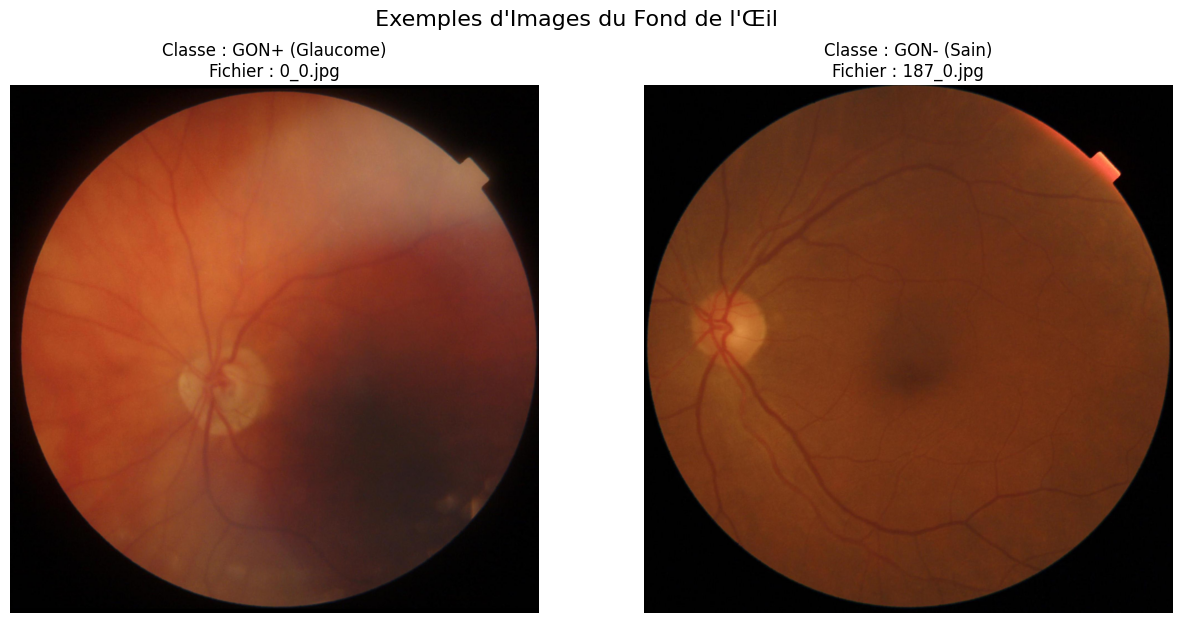

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
import cv2
import os
from google.colab import drive

print("connexion à google drive")
drive.mount('/content/drive')
print("Connexion réussie")

BASE_PATH = '/content/drive/My Drive/Projet_Glaucome/'

CSV_PATH = os.path.join(BASE_PATH, 'Labels.csv')
IMAGE_PATH = os.path.join(BASE_PATH, 'images/')

# --- D. Chargement et Analyse des Labels ---
try:
    df_labels = pd.read_csv(CSV_PATH)
    print("\n Fichier 'Labels.csv' chargé avec succès depuis le bon emplacement.")

    print("\n--- Analyse de la Distribution des Classes ---")
    class_distribution = df_labels['Label'].value_counts()
    print(class_distribution)

    # --- E. Visualisation d'Images Échantillons ---
    print("\n--- Affichage d'un exemple pour chaque classe ---")
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Image Glaucomateuse (GON+)
    sample_gon_plus = df_labels[df_labels['Label'] == 'GON+'].iloc[0]
    full_path_plus = os.path.join(IMAGE_PATH, sample_gon_plus['Image Name'])
    image_plus = cv2.imread(full_path_plus)
    image_plus = cv2.cvtColor(image_plus, cv2.COLOR_BGR2RGB)
    axes[0].imshow(image_plus)
    axes[0].set_title(f"Classe : GON+ (Glaucome)\nFichier : {sample_gon_plus['Image Name']}", fontsize=12)
    axes[0].axis('off')

    # Image Saine (GON-)
    sample_gon_minus = df_labels[df_labels['Label'] == 'GON-'].iloc[0]
    full_path_minus = os.path.join(IMAGE_PATH, sample_gon_minus['Image Name'])
    image_minus = cv2.imread(full_path_minus)
    image_minus = cv2.cvtColor(image_minus, cv2.COLOR_BGR2RGB)
    axes[1].imshow(image_minus)
    axes[1].set_title(f"Classe : GON- (Sain)\nFichier : {sample_gon_minus['Image Name']}", fontsize=12)
    axes[1].axis('off')

    plt.suptitle(" Exemples d'Images du Fond de l'Œil", fontsize=16)
    plt.show()

except FileNotFoundError:
    print(f"\nERREUR : Le fichier ou le dossier est toujours introuvable.")
    print(f"Veuillez vérifier que le chemin suivant est 100% correct : {BASE_PATH}")
except Exception as e:
    print(f"Une erreur est survenue : {e}")

# Phase 2 : Prétraitement et Augmentation des Données
### **1. Séparation Stratifiée des Données** : Nous allons diviser notre jeu de données en trois sous-ensembles distincts : Training Set (75%), Validation Set (15%), Test Set (15%)

### **2. Data Augmentation**: Transformations aléatoires : rotations, zooms, légers décalages, etc.

### **3. Création des générateurs de données**


In [2]:
# Séparation stratifiée des données
X_train, X_temp, y_train, y_temp = train_test_split(
    df_labels['Image Name'],
    df_labels['Label'],
    test_size = 0.3,
    random_state = 42,
    stratify = df_labels['Label']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

train_df = pd.DataFrame({'Image Name':X_train, 'Label': y_train})
validation_df = pd.DataFrame({'Image Name': X_val, 'Label': y_val})
test_df = pd.DataFrame({'Image Name': X_test, 'Label': y_test})

print("\n Repartition des données")
print(f"Taille de l'ensemble d'entrainement: {len(train_df)} images")
print(f"Taille de l'ensemble de validation: {len(validation_df)} images")
print(f"Taille de l'ensemble de test: {len(test_df)} images")
print("\n Distribution dans l'ensemble d'entrainement")
print(train_df['Label'].value_counts(normalize=True))
print("\nDistribution dans l'ensemble de validation :")
print(validation_df['Label'].value_counts(normalize=True))


 Repartition des données
Taille de l'ensemble d'entrainement: 522 images
Taille de l'ensemble de validation: 112 images
Taille de l'ensemble de test: 113 images

 Distribution dans l'ensemble d'entrainement
Label
GON+    0.733716
GON-    0.266284
Name: proportion, dtype: float64

Distribution dans l'ensemble de validation :
Label
GON+    0.732143
GON-    0.267857
Name: proportion, dtype: float64


In [3]:
# Configuration des Générateurs d'Images
IMG_SIZE = 224
BATCH_SIZE = 32

# Generateur pour l'entrainement
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 10,
    height_shift_range = 10,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# Générateur pour la validation et le test (SANS augmentation)
val_test_datagen = ImageDataGenerator(
    rescale = 1./255
)

# Création des flux de données depuis les DataFrames
print("Création des générateurs de données")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Surtout ne pas mélanger les données de test pour une évaluation reproductible.
)


Création des générateurs de données
Found 522 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.
Found 113 validated image filenames belonging to 2 classes.


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

IMG_SIZE = 224

print("\n--- Chargement du modèle de base EfficientNetV2B0 ---")

base_model = EfficientNetV2B0(
    weights = 'imagenet',
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False
)

base_model.trainable = False

print("La base du modèle pré-entrainé a été gélée.")
print(f"le nombre de couche dans la base est: {len(base_model.layers)}")

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.3)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs = base_model.input, outputs = outputs)

print("\n--- Modèle final assemblé ---")

model.summary()





--- Chargement du modèle de base EfficientNetV2B0 ---
La base du modèle pré-entrainé a été gélée.
le nombre de couche dans la base est: 270

--- Modèle final assemblé ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          0 │ rescaling_3[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)